In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
plt.style.use('ggplot')
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False

In [2]:
def plot_distribution(x):
    _, N = x.shape
    plt.figure(figsize=(21,21),dpi=100)
    for i in range(N):
        plt.subplot(5,8,i+1)
        plt.hist(x[:,i], bins=40, facecolor="blue", edgecolor="black", alpha=0.7)
        plt.title("f"+str(i+1)+"分布直方图")
    plt.show()

In [3]:
def MSE(ytrue, ypred):
    return np.sum((ytrue - ypred) ** 2) / ytrue.size

def RMSE(ytrue, ypred):
    return np.sqrt(MSE(ytrue, ypred))

def R2(ytrue, ypred):
    return 1 - MSE(ytrue, ypred) / np.var(ytrue)

In [4]:
# 树结点结构
class TreeNode():
    '''
    index: 结点包含样本的数组下标
    isleaf: 是否为叶子结点，是为TRUE，否为FALSE
    split_f: 划分点选取的特征
    split_v: 划分点选取的特征的值
    weight: 叶子结点的权值
    left: 左孩子结点
    right: 右孩子结点
    '''
    def __init__(self, index):
        self.index = index 
        self.isleaf = False
        self.split_f = None
        self.split_v = None
        self.weight = None
        self.left = None
        self.right = None

In [5]:
# 目标函数的一阶导和二阶导
def obj(ytrue, ypred):
    return 2 * (ypred - ytrue), 2

# 决策树结构
class DecisionTree():
    '''
    max_depth: 树最大深度
    gamma: 叶子结点数正则化系数
    Lambda: 二次正则化项
    subsample: 样本采样比例
    colsample: 特征采样比例
    seed: 随机种子
    lr: 学习率
    '''
    
    __X = None
    __y = None

    @staticmethod
    # 设置共享参数 __X，__y
    def set_data(X, y):
        if DecisionTree.__X is None:
            DecisionTree.__X = X
            DecisionTree.__y = y

    def __init__(self, max_depth, gamma, Lambda, subsample,colsample, seed, lr):
        self.max_depth = max_depth
        self.gamma = gamma
        self.Lambda = Lambda
        self.subsample = subsample
        self.colsample = colsample
        self.seed = seed
        self.eps = 0
        self.lr = lr
        
    # 已知上课树输出，学习当前树
    def fit(self, prior_y):
        # 计算一阶导数g，二阶导数h
        self.__g, self.__h = np.array([obj(y_true, y_pred) for y_true, y_pred in zip(DecisionTree.__y, prior_y)]).T
        # 随机采样，每棵树按照给予的比例随机选取样本和特征进行学习
        np.random.seed(self.seed)
        n, N = DecisionTree.__X.shape
        self.row_samples = np.random.choice(n,round(self.subsample * n),replace=False)
        self.col_samples = np.random.choice(N,round(self.colsample * N),replace=False)
        # 递归建树
        self.tree = self.__create_tree(TreeNode(self.row_samples), depth = 0)
        return self
    
    # 此棵树的输出
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            node = self.tree
            while not node.isleaf:
                if x[node.split_f] <= node.split_v:
                    node = node.left
                else:
                    node = node.right
            pred[i] = node.weight
        return pred
    
    # 按照增益对该结点样本集index划分
    def __split(self, index):
        # 如果该结点的样本少于三个，停止划分
        if len(index) < 3:
            return False, None
        # 计算得分obj1
        gain = -np.inf
        _k = _i = None
        G, H = np.sum(self.__g[index]), np.sum(self.__h[index])
        obj1 = -1/2 * G**2 / (H + self.Lambda + self.eps) + self.gamma
        # 遍历特征
        for k in self.col_samples:
            Gleft, Hleft, Gright, Hright = 0, 0, G, H
            # 对该特征值升序排列
            sorted_index = sorted(index, key=lambda i: DecisionTree.__X[i, k])
            # 遍历该特征的值
            i = 0
            while i < len(sorted_index) - 1:
                idx = sorted_index[i]
                cur_value = DecisionTree.__X[idx, k]
                Gleft += self.__g[idx]
                Hleft += self.__h[idx]
                # 小于等于划分值的都划到左子树
                while i + 1 < len(sorted_index) - 1 and DecisionTree.__X[sorted_index[i + 1], k] == cur_value:
                    i = i + 1
                    idx = sorted_index[i]
                    Gleft += self.__g[idx]
                    Hleft += self.__h[idx]
                Gright, Hright = G - Gleft, H - Hleft
                obj2 = -1/2 * (Gleft**2 / (Hleft + self.Lambda + self.eps) + Gright**2 / (Hright + self.Lambda + self.eps)) + self.gamma
                cur_gain = obj1 - obj2
                # 更新最大的增益
                if cur_gain > gain:
                    gain, _k, _i = cur_gain, k, i
                i = i + 1      
        # 当增益小于阈值时停止划分
        if gain > 0:
            # 利用选择的特征进行值排序
            sorted_index = sorted(index, key=lambda i: DecisionTree.__X[i, _k])
            # 利用选择的特征值进行左右子树划分，返回特征，值，左子树样本下标，右子树样本下标
            return True, (_k, DecisionTree.__X[sorted_index[_i], _k],sorted_index[:_i + 1], sorted_index[_i + 1:])
        else:
            return False, None
        
    # 递归建树 depth为当前深度
    def __create_tree(self, node, depth):
        stop_flag = True  # 结点停止划分标志
        if depth >= self.max_depth: # 超过最大深度停止划分
            stop_flag = False
        if stop_flag: # 划分结点
            stop_flag, split_res = self.__split(node.index)
        if stop_flag: # 更新
            # 选择的特征，划分的值，左孩子样本下标，右孩子样本下标
            f, v, left_index, right_index = split_res
            node.split_f, node.split_v = f, v
            # 对左子树递归划分
            node.left = self.__create_tree(TreeNode(left_index), depth + 1)
            # 对右子树递归划分
            node.right = self.__create_tree(TreeNode(right_index), depth + 1)
        else:
            # 如果结点不再划分，标记为叶结点，并计算权重
            node.isleaf = True
            G, H = np.sum(self.__g[node.index]), np.sum(self.__h[node.index])
            node.weight = self.lr * -G / (H + self.Lambda + self.eps)
        return node

In [6]:
# XGBoost模型
class XGBoost(object):
    '''
    epoch: 最大子树棵树，迭代次数
    max_depth: 每颗子树的最大深度
    lr: 学习率
    Lambda: 二次正则化系数
    gamma: 叶结点个数正则化系数
    subsample: 样本比例
    colsample: 特征比例
    seed: 随机种子
    '''
    def __init__(self,epoch,max_depth = 6,learning_rate = 0.3,gamma = 0,
                 Lambda= 1.0,subsample = 1.0,colsample = 1.0,seed = None):
        self.epoch = epoch
        self.max_depth = max_depth
        self.lr = learning_rate
        self.Lambda = Lambda
        self.gamma = gamma
        self.subsample = subsample
        self.colsample = colsample
        self.seed = seed
    
    # 学习
    def fit(self,X,y,eval_set = None,early_stopping_rounds = None):
        
        self.err = {'train': [], 'val': []}
        self.best_epoch = self.epoch
        self.trees = []
        DecisionTree.set_data(X, y)

        if eval_set is not None:
            cur_val_y = np.zeros(eval_set[1].size)
            if early_stopping_rounds:
                min_val_loss = np.inf
                non_dec_rounds = 0
        
        # 学习第一棵树把先前输出当作0
        cur_y = np.zeros(y.size)
        # 开始学习
        for i in range(self.epoch):
            subtree = DecisionTree(self.max_depth, self.gamma,self.Lambda, self.colsample, self.subsample,self.seed,self.lr)
            # 根据前一棵子树的输出学习下一棵树
            subtree.fit(cur_y)
            self.trees.append(subtree)
            # 更新预测值
            cur_y +=  subtree.predict(X)
            # 更新损失函数
            self.__cal_MSE(y, cur_y, flag='train')
            # 早停
            if eval_set is not None:
                cur_val_y +=  subtree.predict(eval_set[0])
                val_loss = self.__cal_MSE(eval_set[1],cur_val_y, flag='val')
                if early_stopping_rounds:
                    if val_loss < min_val_loss:
                        min_val_loss = val_loss
                        non_dec_rounds = 0
                        self.best_epoch = i + 1
                    else:
                        non_dec_rounds += 1
                        if non_dec_rounds >= early_stopping_rounds:
                            break
        return self
    
    # 输出最终预测结果
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for subtree in self.trees[:self.best_epoch] if self.best_epoch else self.trees:
            pred += subtree.predict(X)
        return pred
    
    # 计算MSE
    def __cal_MSE(self, ytrue, ypred, flag='train'):
        loss = MSE(ytrue, ypred)
        self.err[flag].append(loss)
        return loss
    
    # 绘制损失函数下降曲线
    def loss_curve(self):
        plt.figure(figsize=(10,6),dpi=80)
        plt.title('Learning curve with lr={}'.format(self.lr))
        plt.xlabel('epoch',fontsize=15)
        plt.ylabel('Mean Squared Error',fontsize=15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.plot(np.arange(1,len(self.err['train']) + 1),self.err['train'],label='Training Error')
        if self.err['val']:
            plt.plot(np.arange(1,len(self.err['val']) + 1),self.err['val'],label='Validation Error')
        plt.legend(fontsize=15)
        plt.show()

In [7]:
# 读入数据
names=[]
for i in range(40):
    names.append('f'+str(i+1))
names.append('label')
df=pd.read_csv("train.data",names=names)
columns=[24,25,26,27,28,29,30,31,32,33,34,35,36,37]
df=df.drop(df.columns[columns],axis = 1)

n,N = df.shape
x=df.iloc[:,0:N-1]
y=df['label']
x_train = np.array(x[:round(0.8 * n)])
y_train = np.array(y[:round(0.8 * n)])
x_eval = np.array(x[round(0.8 * n):])
y_eval = np.array(y[round(0.8 * n):])

df_=pd.read_csv("ailerons.test",names=names)
df_=df_.drop(df_.columns[columns],axis = 1)
n,N = df_.shape
x=df_.iloc[:,0:N-1]
y=df_['label']
x_test = np.array(x)
y_test = np.array(y)

best epoch: 60
train RMSE = 0.00014730326866206693
train R2 = 0.8702823499569419
eval RMSE = 0.0001767684517031114
eval R2 = 0.8218652556218256
test RMSE = 0.00016594619576770385
test R2 = 0.8304117911610132


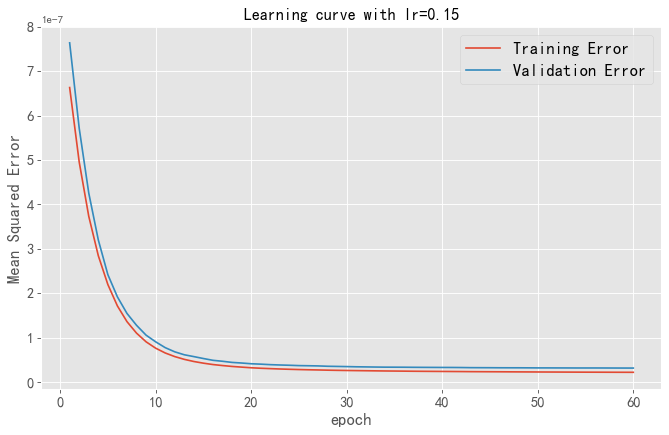

In [9]:
xgb = XGBoost(epoch=60,max_depth=3,learning_rate=0.15,gamma=0,Lambda=1,subsample=1,colsample=1,seed=123)

xgb.fit(x_train, y_train, eval_set=(x_eval, y_eval), early_stopping_rounds=20)

print('best epoch: {}'.format(xgb.best_epoch))

ypred_train = xgb.predict(x_train)
ypred_eval = xgb.predict(x_eval)
ypred_test = xgb.predict(x_test)
print("train RMSE = {}".format(RMSE(y_train, ypred_train)))
print("train R2 = {}".format(R2(y_train, ypred_train)))
print("eval RMSE = {}".format(RMSE(y_eval, ypred_eval)))
print("eval R2 = {}".format(R2(y_eval, ypred_eval)))
print("test RMSE = {}".format(RMSE(y_test, ypred_test)))
print("test R2 = {}".format(R2(y_test, ypred_test)))
xgb.loss_curve()

In [26]:
np.savetxt("pred_label.txt", ypred_test)